# Importing libraries

In [1]:
import os
import torch, pyro, numpy as np
torch.set_default_tensor_type(torch.cuda.FloatTensor)
from torch import tensor
import torch.nn as nn
import torchvision.transforms.functional as TF
from tqdm import tqdm
import pandas as pd


from clipppy import load_config, Clipppy
from clipppy.patches import torch_numpy
from ruamel.yaml import YAML

import swyft
import pyro.distributions as dist

import matplotlib.pyplot as plt
imkwargs = dict(extent=(-2.5, 2.5, -2.5, 2.5), origin='lower')

import sys
sys.path.append('/home/eliasd/lensing/elias_utils')
from plotting import *

plt.rcParams.update({'font.size': 15})

from utils import *

from network import UNET, CustomHead

DEVICE = 'cuda'

# Defining functions

In [2]:
def get_run(m, nsub, nsim):
    RUN = f'_m{m}_nsub{nsub}_nsim{nsim}'
    return RUN

def get_store(RUN):
    SIM_PATH = f'/nfs/scratch/eliasd/store{RUN}.zarr' 
    assert os.path.exists(f'/nfs/scratch/eliasd/store{RUN}.sync')
    store = swyft.DirectoryStore(path=SIM_PATH)
    print(f'Store has {len(store)} simulations')
    return store

def get_post(RUN, lr, factor, patience):
    save_name, save_path = get_name(RUN, lr, factor, patience)
    print(save_name)
    assert os.path.isfile(save_path)
    post = swyft.Posteriors.load(save_path).to(DEVICE)
    return post

In [3]:
def get_losses(post):
        
    keys = list(post._ratios.keys())
    assert len(keys) == 1
    losses = post._ratios[keys[0]]._train_diagnostics
    assert len(losses) == 1
    tl = losses[0]['train_loss']
    vl = losses[0]['valid_loss']
    epochs = np.arange(len(tl))
    return epochs, tl, vl

def plot_losses(post, title = ''):
    fig, ax = plt.subplots(1, 1)
    
    epochs, tl, vl = get_losses(post)
        
    ax.plot(epochs, tl, '--', label = f'training loss')
    ax.plot(epochs, vl, '-', label = f'val loss')
    
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    plt.legend()
    plt.show()

In [4]:
def ratio(w):
    r = np.zeros((L**2))
    for i, (key, value) in enumerate(w.items()):
        r[i] = value
    return r.T.reshape(L, L)

def get_ratio(post, obs0, coords):
    samples = post.sample_elias(N = 1, obs0 = (obs0), n_batch = 1, v = coords.view(1, -1))
    v = samples['v']
    w = samples['weights']
    return ratio(w)

In [5]:
def plot_pred(post, store, n = 1):
    
    for i in np.random.randint(0, len(store), n):
        obs0 = store[i][0]
        v0 = store[i][1]

        p_0 = get_ratio(post, obs0, xy_empty)/(L*L)
        p_1 = get_ratio(post, obs0, xy_full)/(L*L)

        plots = [obs0['image'], p_0, p_1]
        plt_imshow(plots, titles = ['Observation', 'Posterior NO subhalo', 'Posterior subhalo'], scatter = [v0]*len(plots), size_y = 3, **imkwargs)

        plt.show()

# Importing data

In [6]:
RUN_9_3 = get_run(9, 3, 10000)
store_9_3 = get_store(RUN_9_3)

RUN_10 = get_run(10, 1, 10000)
store_10 = get_store(RUN_10)

RUN_10_3 = get_run(10, 3, 10000)
store_10_3 = get_store(RUN_10_3)

RUN_10_3_5 = get_run(10, 3, 50000)
store_10_3_5 = get_store(RUN_10_3_5)

RUN_0_3 = get_run(0, 3, 10000)
store_0_3 = get_store(RUN_0_3)

RUN_0_3_5 = get_run(0, 3, 50000)
store_0_3_5 = get_store(RUN_0_3_5)

RUN_1_3 = get_run(1, 3, 10000)
store_1_3 = get_store(RUN_1_3)

RUN_11 = get_run(11, 1, 10000)
store_11 = get_store(RUN_11)

Loading existing store.
Store has 9907 simulations
Loading existing store.
Store has 10056 simulations
Loading existing store.
Store has 10083 simulations
Loading existing store.
Store has 50268 simulations
Loading existing store.
Store has 10052 simulations
Loading existing store.
Store has 50228 simulations
Loading existing store.
Store has 10072 simulations
Loading existing store.
Store has 9982 simulations


In [7]:
L = 40
uuu = UNET(1, 1)
grid = torch.linspace(0,(L-1)/L,L)
x, y = torch.meshgrid(grid, grid, indexing = 'xy')
xy_full = torch.transpose(torch.stack((x.flatten(), y.flatten())), 0, 1).flatten()
xy_empty = tensor(())

plots = [uuu.coord_to_map(xy.view(1, -1).to(DEVICE)).cpu().squeeze() for xy in [xy_empty, xy_full]]
# plt_imshow(plots, cbar = True, size_y = 2)

In [8]:
post_a = get_post(RUN_10, 1e-3, 1e-1, 5)
post_b = get_post(RUN_10, 1e-3, 3e-4, 5)
post_c = get_post(RUN_11, 1e-3, 3e-4, 5)
post_d = get_post(RUN_11, 1e-4, 3e-4, 5)

UNet_m10_nsub1_nsim10000_lr-3.0_fac-1.0_pat5.pt
UNet_m10_nsub1_nsim10000_lr-3.0_fac-3.5228787452803374_pat5.pt
UNet_m11_nsub1_nsim10000_lr-3.0_fac-3.5228787452803374_pat5.pt
UNet_m11_nsub1_nsim10000_lr-4.0_fac-3.5228787452803374_pat5.pt


# Plot results

In [36]:
save_paths, save_names = np.array([(os.path.join('posts', save_name), save_name)
              for save_name in os.listdir('posts') if save_name.startswith(f'UNet{RUN_1_3}')]).T

In [37]:
save_paths

array(['posts/UNet_m1_nsub3_nsim10000_lr-3.0_fac-1.0_pat5.pt'],
      dtype='<U52')

In [38]:
posts = []

for save_path in save_paths:
    
    assert os.path.isfile(save_path)
    post = swyft.Posteriors.load(save_path).to(DEVICE)
    
    posts.append(post)

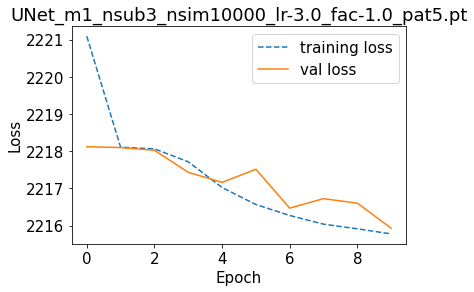

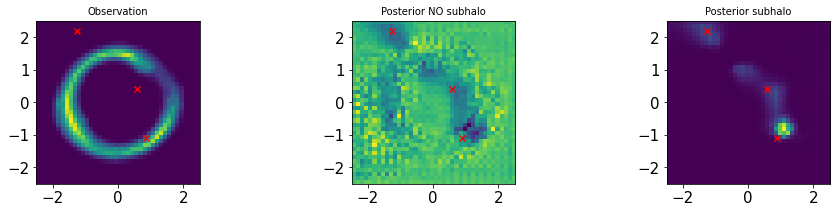

In [39]:
for post, save_name in zip(posts, save_names):
    plot_losses(post, save_name)
    plot_pred(post, store_1_3, 1)

In [21]:
sdf = pd.read_pickle('posts_gridsearch/trials.pkl')

In [26]:
df

,number,value,datetime_start,datetime_complete,duration,params_factor,params_lr,params_patience,state
4,4,2217.627214,2021-12-06 18:24:30.476271,2021-12-06 18:27:40.357503,0 days 00:03:09.881232,0.001242,0.000160,5,COMPLETE
2,2,2218.013216,2021-12-06 18:18:04.892660,2021-12-06 18:21:20.513533,0 days 00:03:15.620873,0.037919,0.000053,4,COMPLETE
19,19,2218.019255,2021-12-06 19:12:08.796141,2021-12-06 19:15:17.709718,0 days 00:03:08.913577,0.045722,0.000063,3,COMPLETE
16,16,2218.026025,2021-12-06 19:02:36.731275,2021-12-06 19:05:45.289737,0 days 00:03:08.558462,0.001734,0.000294,4,COMPLETE
15,15,2218.027686,2021-12-06 18:59:22.757396,2021-12-06 19:02:36.729297,0 days 00:03:13.971901,0.018604,0.000089,5,COMPLETE
17,17,2218.051270,2021-12-06 19:05:45.291695,2021-12-06 19:08:54.051829,0 days 00:03:08.760134,0.000399,0.000135,5,COMPLETE
12,12,2218.063053,2021-12-06 18:49:54.175267,2021-12-06 18:53:05.004847,0 days 00:03:10.829580,0.006487,0.000110,5,COMPLETE
5,5,2218.076449,2021-12-06 18:27:40.359352,2021-12-06 18:30:53.656755,0 days 00:03:13.297403,0.000994,0.000056,5,COMPLETE
11,11,2218.085954,2021-12-06 18:46:44.357203,2021-12-06 18:49:54.173272,0 days 00:03:09.816069,0.086000,0.000165,4,COMPLETE
7,7,2218.089290,2021-12-06 18:34:04.138299,2021-12-06 18:37:13.036712,0 days 00:03:08.898413,0.001061,0.000216,5,COMPLETE


In [23]:
save_names = []
posts = []
for i in range(10):
    lr, factor, patience = df.iloc[i][['params_lr', 'params_factor', 'params_patience']].values
    save_name, save_path = get_name(RUN_0_3, lr, factor, patience, 'posts_gridsearch')
    
    assert os.path.isfile(save_path)
    
    post = swyft.Posteriors.load(save_path).to(DEVICE)
    
    save_names.append(save_name)
    posts.append(post)

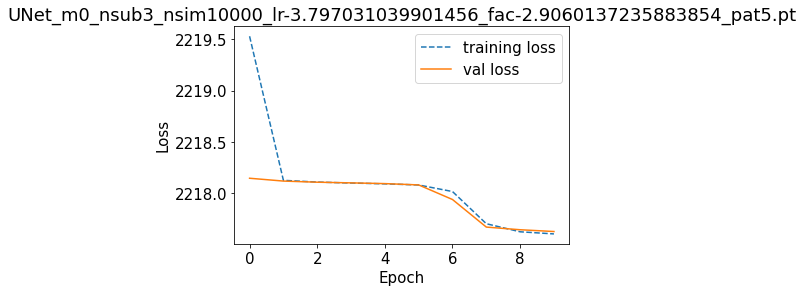

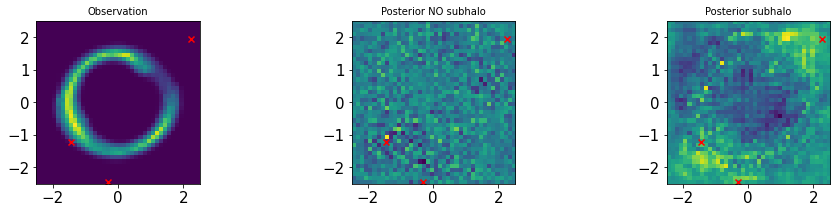

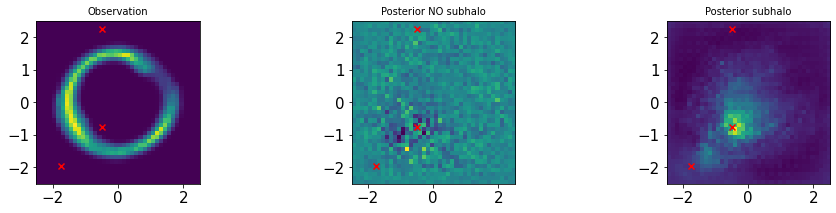

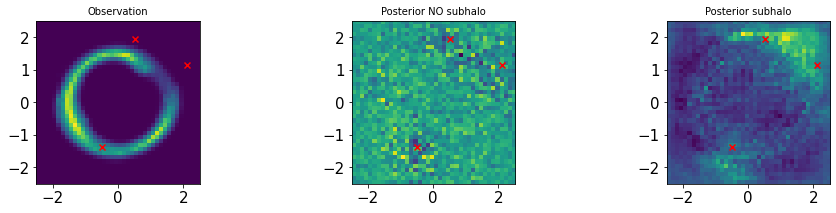

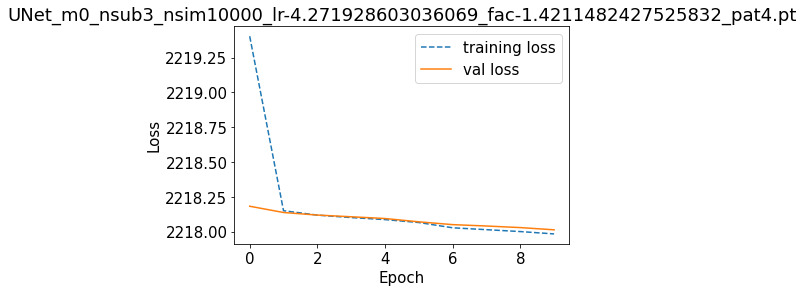

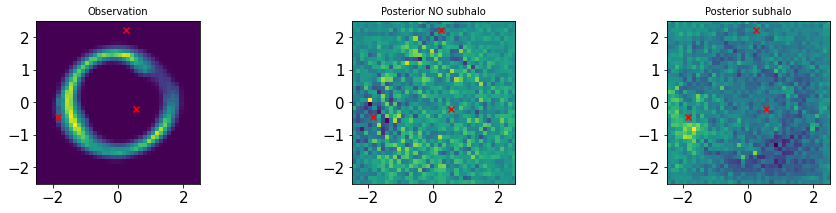

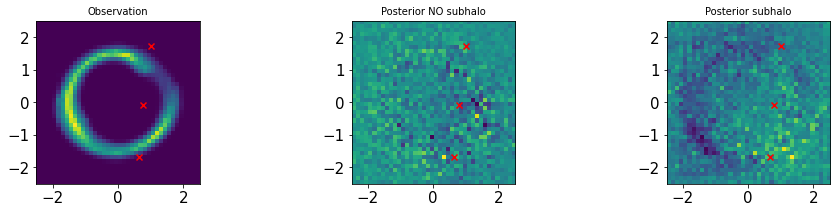

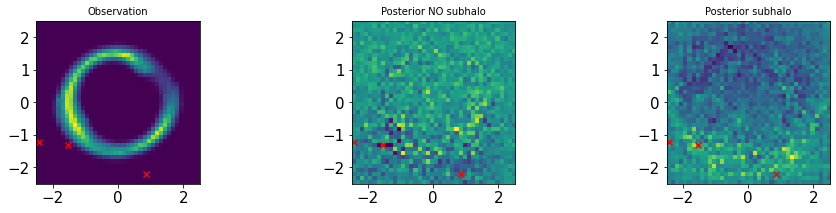

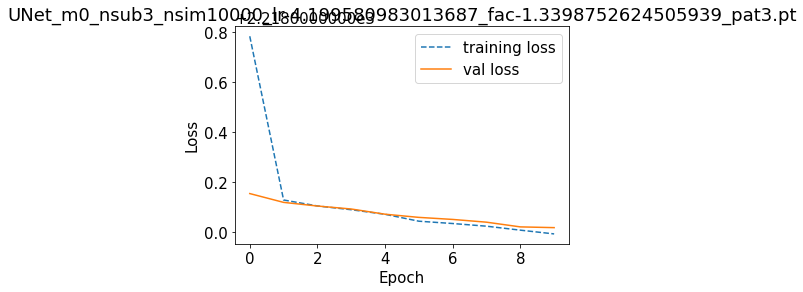

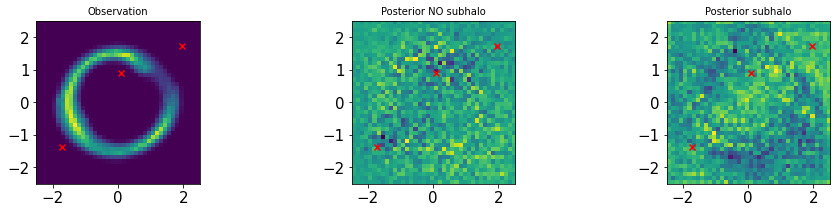

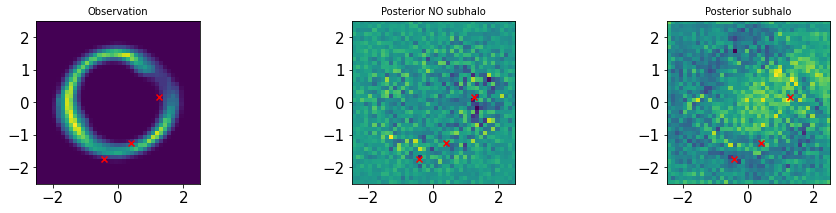

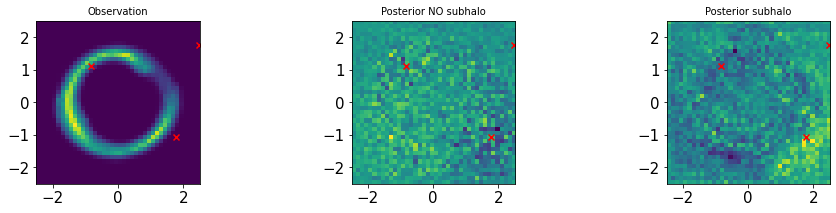

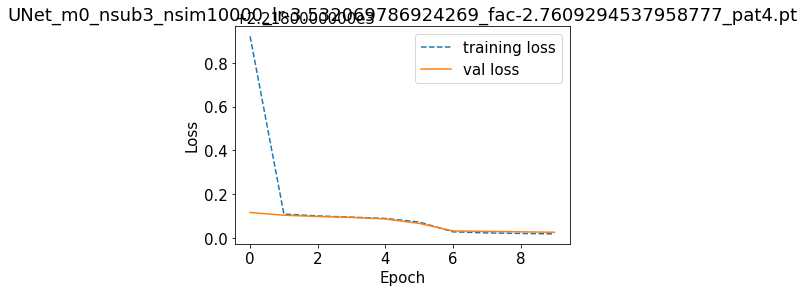

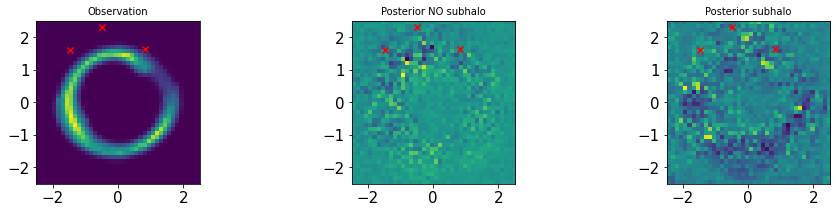

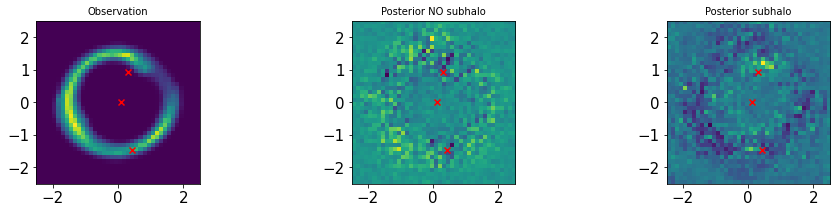

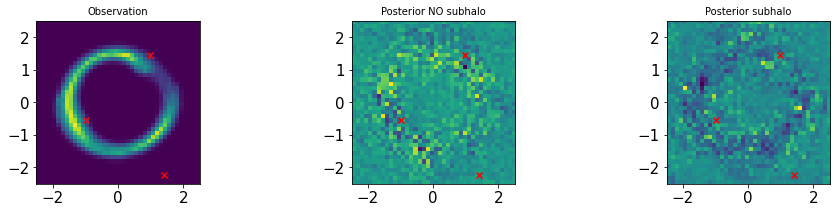

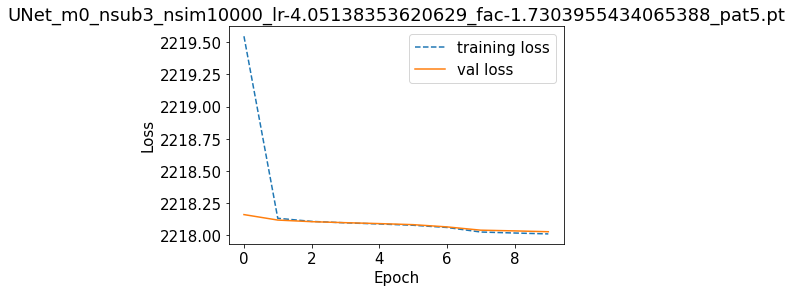

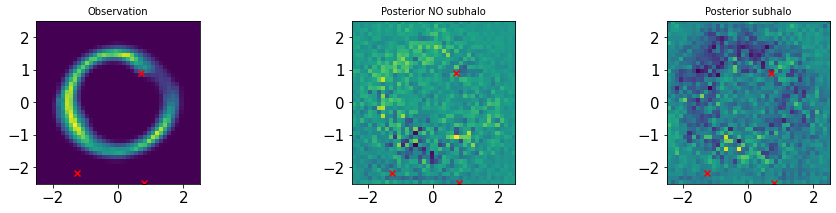

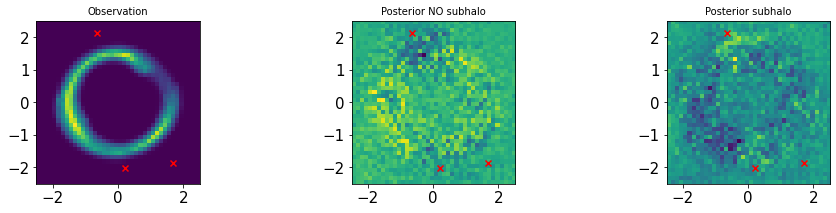

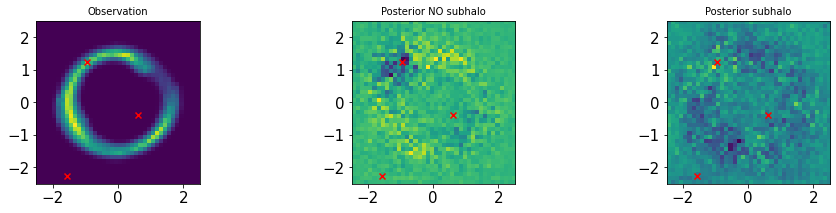

In [25]:
for post, save_name in zip(posts[:5], save_names):
    plot_losses(post, save_name)
    plot_pred(post, store_0_3, 3)

UNet_m10_nsub3_nsim50000_lr-3.0_fac-1.0_pat5.pt


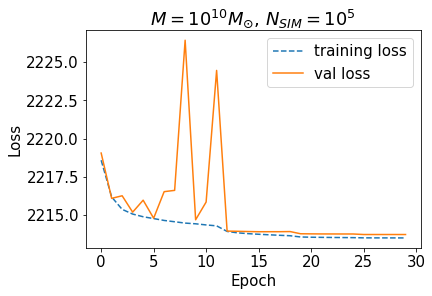

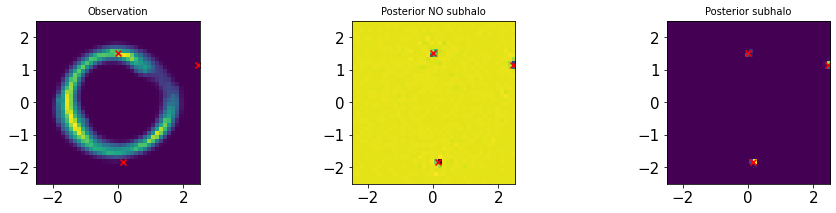

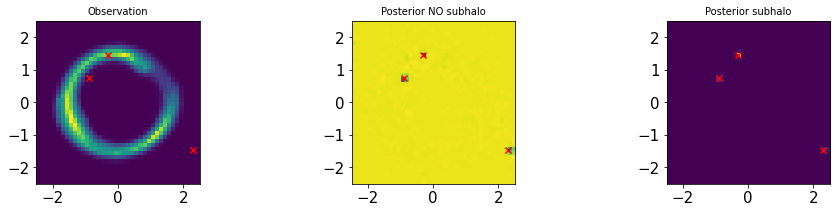

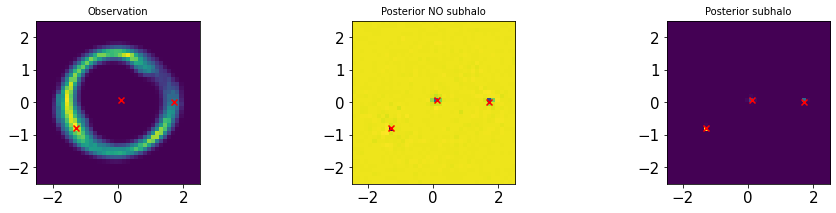

In [12]:
post = get_post(RUN_10_3_5, 1e-3, 1e-1, 5)
store = store_10_3_5

plot_losses(post, '$M = 10^{10}M_{\odot}$, $N_{SIM} = 10^5$')
plot_pred(post, store, 3)

In [ ]:
post = get_post(RUN_0_3_5, 1e-3, 1e-1, 5)
store = store_0_3_5

plot_losses(post, '$M = 10^{10}M_{\odot}$, $N_{SIM} = 10^5$')
plot_pred(post, store, 3)

UNet_m10_nsub3_nsim50000_lr-3.0_fac-1.0_pat5.pt


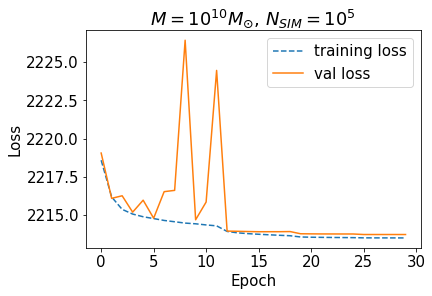

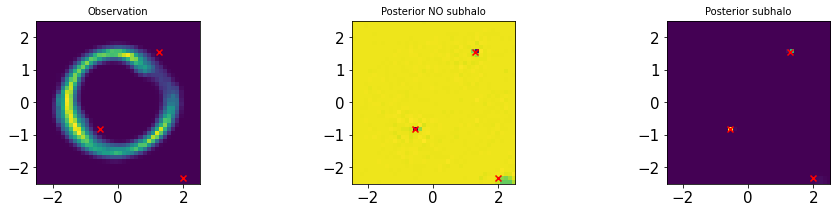

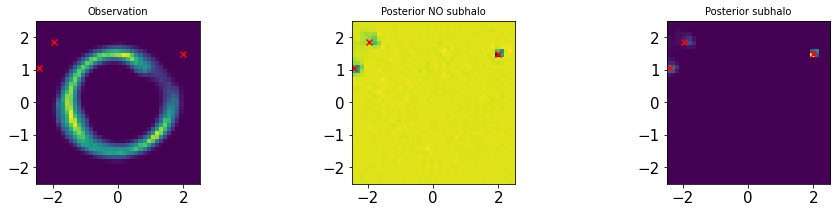

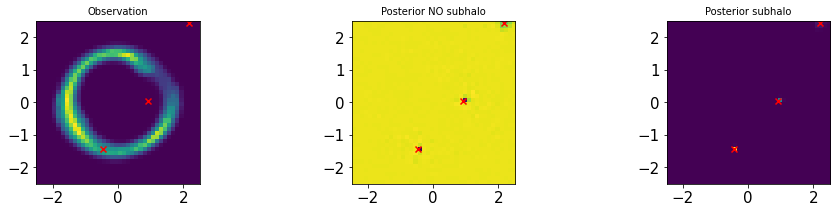

In [13]:
post = get_post(RUN_10_3_5, 1e-3, 1e-1, 5)
store = store_10_3_5

plot_losses(post, '$M = 10^{10}M_{\odot}$, $N_{SIM} = 10^5$')
plot_pred(post, store, 3)

UNet_m1_nsub3_nsim10000_lr-3.0_fac-1.0_pat5.pt


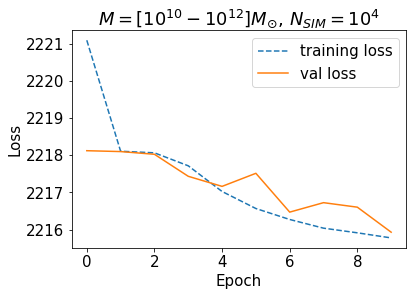

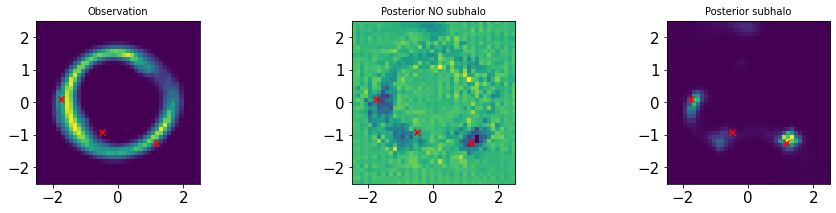

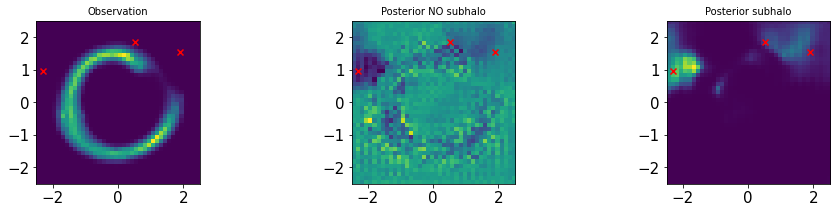

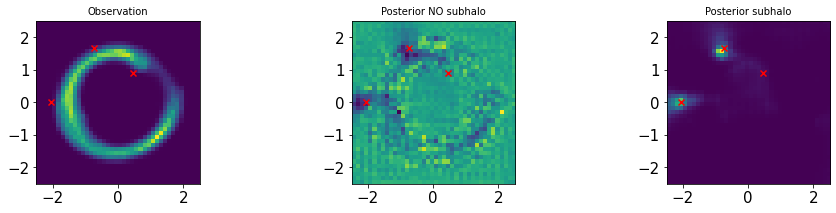

In [14]:
post = get_post(RUN_1_3, 1e-3, 1e-1, 5)
store = store_1_3

plot_losses(post, '$M = [10^{10} - 10^{12}]M_{\odot}$, $N_{SIM} = 10^4$')
plot_pred(post, store, 3)

UNet_m9_nsub3_nsim10000_lr-3.0_fac-1.0_pat5.pt


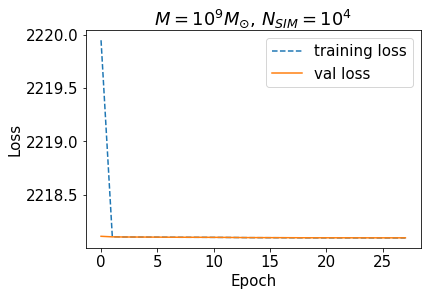

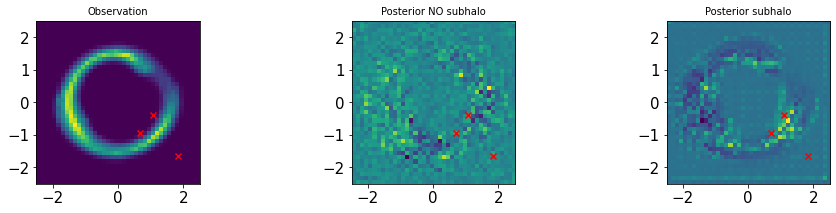

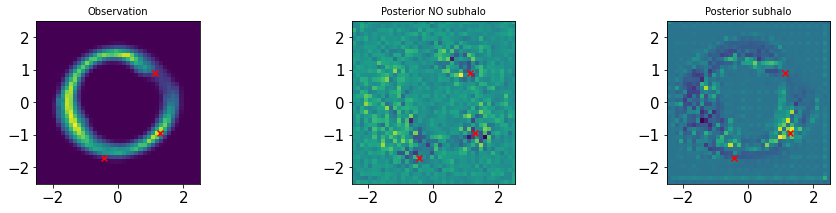

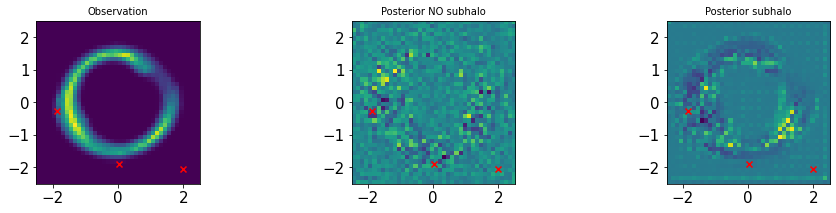

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]),
 [2219.950024940985,
  2218.1043393800583,
  2218.1019822813623,
  2218.101270936376,
  2218.1007914371626,
  2218.1003435532825,
  2218.099793797774,
  2218.0990525938623,
  2218.098761030238,
  2218.0985379665017,
  2218.098116428732,
  2218.0975684296313,
  2218.096807905238,
  2218.0957382531474,
  2218.095416830598,
  2218.0951375618256,
  2218.094810870054,
  2218.094434998876,
  2218.0939607688847,
  2218.0935515259666,
  2218.0934549235612,
  2218.093393449303,
  2218.0933108981567,
  2218.0932406418615,
  2218.0931668727517,
  2218.0930755395684,
  2218.0930702703463,
  2218.0930579754945],
 [2218.1082356770835,
  2218.102994791667,
  2218.101741536458,
  2218.101350911458,
  2218.100927734375,
  2218.100374348958,
  2218.099788411458,
  2218.099397786458,
  2218.0991373697916,
  2218.098909505208,
  2218.0984049479166,
  2218.097835286458,
  2218.0

In [15]:
post = get_post(RUN_9_3, 1e-3, 1e-1, 5)
store = store_9_3

plot_losses(post, '$M = 10^{9}M_{\odot}$, $N_{SIM} = 10^4$')

plot_pred(post, store, 3)

# Play around

In [16]:
assert 1 == 2

AssertionError: 

In [ ]:
SYSTEM_NAME = "ngc4414" 
nsub = 3
m = 0

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
CONFIG = get_config(SYSTEM_NAME, str(nsub), str(m))
torch.set_default_tensor_type(torch.FloatTensor)

torch.set_default_tensor_type(torch.cuda.FloatTensor)  # HACK
ppd = CONFIG.ppd()['model_trace'].nodes
torch.set_default_tensor_type(torch.FloatTensor)

In [ ]:
ppd['main/sub/p_sub']

In [ ]:
CONFIG.umodel.alphas["main"].sub.nsub

In [ ]:
posts = [post_a, post_b, post_c, post_d]
stores = [store_10, store_10, store_11, store_11, ]

In [ ]:
for post, store in zip(posts, stores):
    plot_pred(post, store, 3)